In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
file_path = "/content/drive/MyDrive/DistilBERT-7-Mei/combined_dataset_added.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Unnamed: 0,Label,clean_text,String,encoded_label
0,0,Non-bullying,kaka tidur yaa sudah pagi tidak boleh capek2,"""Kaka tidur yaa, udah pagi, gaboleh capek2""",1.0
1,1,Non-bullying,makan nasi padang saja badannya,"""makan nasi padang aja begini badannya""",1.0
2,2,Bullying,suka cukur jembut manggung,"""yang aku suka dari dia adalah selalu cukur je...",0.0
3,3,Non-bullying,hai kak isyana ngefans sekali kak isyana suka ...,"""Hai kak Isyana aku ngefans banget sama kak Is...",1.0
4,4,Non-bullying,manusia bidadari sih herann deh cantik,"""Manusia apa bidadari sih herann deh cantik te...",1.0


In [4]:
df['Label'].unique()

array(['Non-bullying', 'Bullying', 'positif', 'negatif', 'negative',
       'positive', 'tidak bully', 'bullying'], dtype=object)

In [5]:
# Mapping dictionary
label_map = {
    'Bullying': 'Bullying',
    'bullying': 'Bullying',
    'negative': 'Bullying',
    'negatif': 'Bullying',

    'Non-bullying': 'Non-bullying',
    'tidak bully': 'Non-bullying',
    'positive': 'Non-bullying',
    'positif': 'Non-bullying'
}

# Apply mapping
df['Label'] = df['Label'].map(label_map)

# Cek hasil unique setelah diselaraskan
print(df['Label'].unique())


['Non-bullying' 'Bullying']


Komposisi Label:
encoded_label
0.0    1830
1.0    1605
Name: count, dtype: int64

Persentase Label (%):
encoded_label
0.0    53.28
1.0    46.72
Name: proportion, dtype: float64


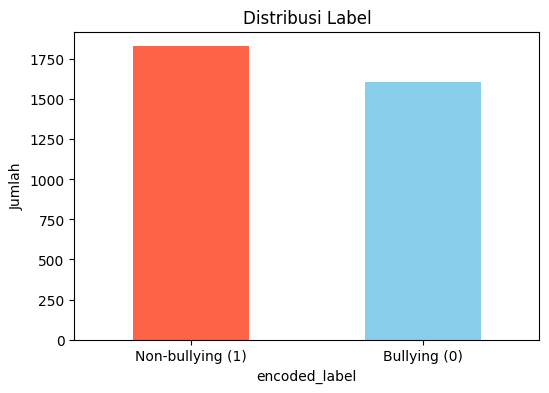

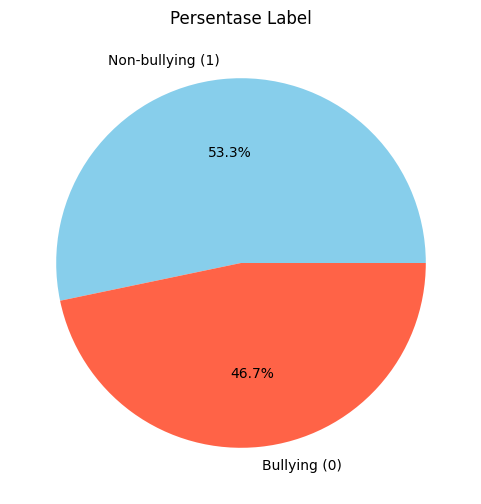

In [6]:
import matplotlib.pyplot as plt

# Hitung jumlah tiap label
label_counts = df['encoded_label'].value_counts()

# Hitung persentase tiap label
label_percent = df['encoded_label'].value_counts(normalize=True) * 100

# Tampilkan hasil
print("Komposisi Label:")
print(label_counts)
print("\nPersentase Label (%):")
print(label_percent.round(2))

# Visualisasi Bar Chart
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['tomato','skyblue'])
plt.xticks([0,1], ['Non-bullying (1)', 'Bullying (0)'], rotation=0)
plt.ylabel("Jumlah")
plt.title("Distribusi Label")
plt.show()

# Visualisasi Pie Chart
plt.figure(figsize=(6,6))
label_counts.plot(kind='pie', autopct='%1.1f%%', labels=['Non-bullying (1)', 'Bullying (0)'], colors=['skyblue','tomato'])
plt.ylabel("")
plt.title("Persentase Label")
plt.show()

In [7]:
!pip install gensim
!pip install optuna


  Using cached optuna-4.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.5.0-py3-none-any.whl (400 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [8]:
import optuna
import pandas as pd
import numpy as np
import gensim
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


# Split Train-Test Dataset :

In [9]:
X = df['clean_text'].astype(str)
y = df['encoded_label']

# LabelEncoder untuk nama kelas
le = LabelEncoder()
le.fit(df['Label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tokenisasi & Padding

In [10]:
max_words = 20000
max_len = 50

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


# Load Pre-trained FastText

In [11]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
!gunzip cc.id.300.vec.gz


--2025-09-23 01:40:54--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.240.184.75, 54.240.184.92, 54.240.184.45, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.240.184.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1227018698 (1.1G) [binary/octet-stream]
Saving to: ‘cc.id.300.vec.gz’

cc.id.300.vec.gz    100%[===================>]   1.14G   160MB/s    in 7.3s    

2025-09-23 01:41:01 (160 MB/s) - ‘cc.id.300.vec.gz’ saved [1227018698/1227018698]



# Import Pre-Trained embedding fastext ke framework Gensim :

In [12]:
from gensim.models import KeyedVectors

fasttext_model = KeyedVectors.load_word2vec_format('cc.id.300.vec', binary=False)
embedding_dim = 300  # ukuran embedding dari fastText


# Membuat Embedding Matrix :

In [13]:
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in fasttext_model:
        embedding_matrix[i] = fasttext_model[word]

# Optuna Model Function :

In [16]:
def create_model(trial):
    model = Sequential()
    model.add(Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ))

    # Hyperparameter tuning: GRU units
    gru_units = trial.suggest_categorical("gru_units", [64, 128, 256])
    model.add(Bidirectional(GRU(gru_units, return_sequences=False)))

    # Hyperparameter tuning: Dropout
    dropout_rate = trial.suggest_float("dropout", 0.3, 0.6, step=0.1)
    model.add(Dropout(dropout_rate))

    # Hyperparameter tuning: Dense layer
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128])
    model.add(Dense(dense_units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    # Hyperparameter tuning: Learning rate
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


# Optuna Objective Function :

In [25]:
def objective(trial):
    model = create_model(trial)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )

    val_acc = max(history.history['val_accuracy'])
    return val_acc


# Jalankan Hyperparameter Tuning :

In [26]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # coba 10x, bisa dinaikkan

print("Best trial:", study.best_trial.params)


[I 2025-09-23 02:28:06,533] A new study created in memory with name: no-name-c44e15d6-0fc6-4877-897f-a4099a01e3ea
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-23 02:28:25,776] Trial 0 finished with value: 0.807272732257843 and parameters: {'gru_units': 64, 'dropout': 0.5, 'dense_units': 64, 'learning_rate': 0.0001, 'batch_size': 32}. Best is trial 0 with value: 0.807272732257843.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-23 02:28:37,659] Trial 1 finished with value: 0.8018181920051575 and parameters: {'gru_units': 256, 'dropout': 0.5, 'dense_units': 64, 'learning_rate': 0.0001, 'batch_size': 128}. Best is trial 0 with value: 0.807272732257843.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWa

Best trial: {'gru_units': 256, 'dropout': 0.3, 'dense_units': 64, 'learning_rate': 0.01, 'batch_size': 128}


# Train Model dengan Best Params :

In [ ]:
best_params = study.best_trial.params
print("Training dengan best params:", best_params)

final_model = create_model(study.best_trial)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

final_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=best_params["batch_size"],
    callbacks=callbacks,
    verbose=1
)


Training dengan best params: {'gru_units': 256, 'dropout': 0.5, 'dense_units': 128, 'learning_rate': 0.01, 'batch_size': 64}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.6047 - loss: 0.6630 - val_accuracy: 0.7236 - val_loss: 0.5496 - learning_rate: 0.0100
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7784 - loss: 0.4776 - val_accuracy: 0.8000 - val_loss: 0.4548 - learning_rate: 0.0100
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7980 - loss: 0.4440 - val_accuracy: 0.8091 - val_loss: 0.4477 - learning_rate: 0.0100
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8694 - loss: 0.3251 - val_accuracy: 0.8309 - val_loss: 0.4003 - learning_rate: 0.0100
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9109 - loss: 0.2352 - val_accuracy: 0.8236 - val_loss: 0.4152 - learning_rate: 0.0100
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9430 - loss: 0.1525 - val_accuracy: 0.8273 - val_loss: 0.4817 - learning_rate: 0.0100
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9691 - loss: 0.0872 - val_accuracy: 0.82

# Evaluasi hasil train model Bi-GRU + Optuna :

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

    Bullying       0.81      0.91      0.86       374
Non-bullying       0.87      0.75      0.81       313

    accuracy                           0.84       687
   macro avg       0.84      0.83      0.83       687
weighted avg       0.84      0.84      0.83       687



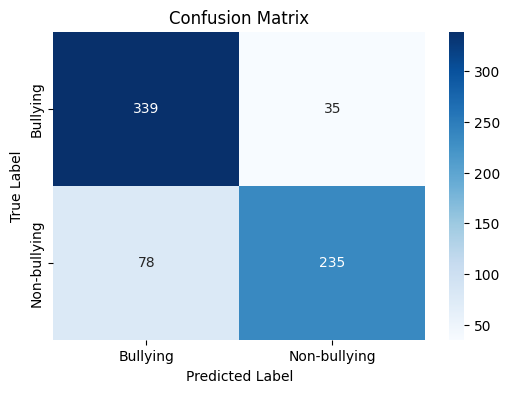

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = (final_model.predict(X_test_pad) > 0.5).astype("int32")

# Classification Report
class_names = le.inverse_transform([0, 1])
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Melakukan Uji-Coba tanpa EarlyStooping Dan ReduceLROnPlateau

# Optuna Objective Function :

In [20]:
def objective(trial):
    model = create_model(trial)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=20,
        batch_size=batch_size,
        verbose=0
    )

    val_acc = max(history.history['val_accuracy'])
    return val_acc


# Menjalankan Hyperparameter Tuning :

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # coba 10x, bisa dinaikkan

print("Best trial:", study.best_trial.params)


[I 2025-09-23 02:15:23,136] A new study created in memory with name: no-name-b1ab4cb2-1aac-4cfa-a7e9-7a1c56d4cae7
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-23 02:15:43,087] Trial 0 finished with value: 0.8145454525947571 and parameters: {'gru_units': 128, 'dropout': 0.5, 'dense_units': 32, 'learning_rate': 0.001, 'batch_size': 128}. Best is trial 0 with value: 0.8145454525947571.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2025-09-23 02:16:02,841] Trial 1 finished with value: 0.8054545521736145 and parameters: {'gru_units': 256, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.0001, 'batch_size': 32}. Best is trial 0 with value: 0.8145454525947571.
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: Use

Best trial: {'gru_units': 128, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.01, 'batch_size': 32}


# Train-Ulang tanpa Early Stopping :

In [23]:
best_params = study.best_trial.params
print("Training dengan best params:", best_params)

final_model = create_model(study.best_trial)

final_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=best_params["batch_size"],
    verbose=1
)


Training dengan best params: {'gru_units': 128, 'dropout': 0.4, 'dense_units': 64, 'learning_rate': 0.01, 'batch_size': 32}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6180 - loss: 0.6166 - val_accuracy: 0.7600 - val_loss: 0.4936
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8003 - loss: 0.4363 - val_accuracy: 0.7945 - val_loss: 0.4380
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8294 - loss: 0.3556 - val_accuracy: 0.8364 - val_loss: 0.3968
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9053 - loss: 0.2293 - val_accuracy: 0.8382 - val_loss: 0.4055
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9353 - loss: 0.1569 - val_accuracy: 0.8164 - val_loss: 0.3909
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9318 - loss: 0.1607 - val_accuracy: 0.8291 - val_loss: 0.4254
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9278 - loss: 0.1881 - val_accuracy: 0.7527 - val_loss: 0.5078
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8592 - loss: 0.3396 - val_accuracy: 0.8255 - v

# Evaluasi hasil train model Bi-GRU + Optuna tanpa earlystopping (full epoch) :

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
              precision    recall  f1-score   support

    Bullying       0.84      0.84      0.84       374
Non-bullying       0.81      0.81      0.81       313

    accuracy                           0.83       687
   macro avg       0.83      0.83      0.83       687
weighted avg       0.83      0.83      0.83       687



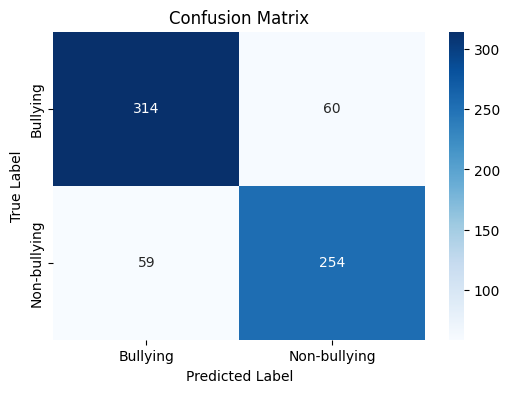

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prediksi
y_pred = (final_model.predict(X_test_pad) > 0.5).astype("int32")

# Classification Report
class_names = le.inverse_transform([0, 1])
print(classification_report(y_test, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Melakukan Uji-Coba tanpa menggunakan Optuna (Pakai Baseline) :

In [27]:
import tensorflow as tf
tf.keras.backend.clear_session()

# Bangun Model Bi-GRU

In [28]:
model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # pre-trained tidak di-train ulang
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,875,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,300 (7.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,875,300 (7.15 MB)

# Train model Bi-GRU dengan baseline parameters kita :

In [29]:
history = model.fit(X_train_pad, y_train,
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32,
                    verbose=1)


Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5821 - loss: 0.6664 - val_accuracy: 0.7527 - val_loss: 0.4975
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7822 - loss: 0.4719 - val_accuracy: 0.7564 - val_loss: 0.4921
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8226 - loss: 0.4050 - val_accuracy: 0.7727 - val_loss: 0.4625
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8444 - loss: 0.3578 - val_accuracy: 0.7909 - val_loss: 0.4552
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8440 - loss: 0.3533 - val_accuracy: 0.7964 - val_loss: 0.4770
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8782 - loss: 0.3187 - val_accuracy: 0.8055 - val_loss: 0.4610
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8872 - loss: 0.2916 - val_accuracy: 0.7891 - val_loss: 0.4810
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8997 - loss: 0.2578 - val_accuracy: 0.7873 - v

# Evaluasi Model dengan baseline parameter tanpa optuna :

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

    Bullying       0.78      0.91      0.84       374
Non-bullying       0.87      0.69      0.77       313

    accuracy                           0.81       687
   macro avg       0.83      0.80      0.81       687
weighted avg       0.82      0.81      0.81       687


Confusion Matrix (Tabel):

              Bullying  Non-bullying
Bullying           342            32
Non-bullying        96           217


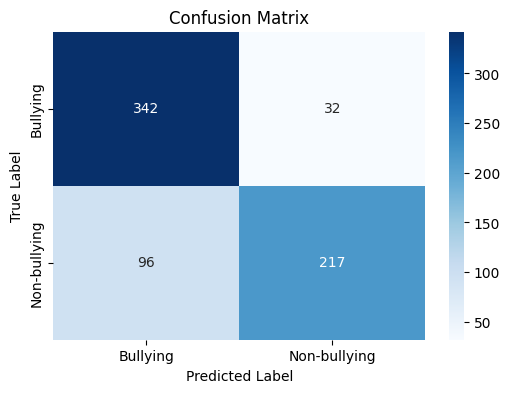

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Prediksi
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# 🔹 Get the class names for labels 0 and 1
class_names = le.inverse_transform([0, 1])

# 🔹 Classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# 🔹 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Tampilkan sebagai tabel (pandas DataFrame)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion Matrix (Tabel):\n")
print(cm_df)

# ✅ Visualisasi heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Mencoba dengan total 20 Epoch :

In [31]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [32]:
model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # pre-trained tidak di-train ulang
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,875,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,300 (7.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,875,300 (7.15 MB)

In [33]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,              # full 20 epoch
    batch_size=32,          # tetap optimal untuk NLP
    verbose=1
)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5936 - loss: 0.6597 - val_accuracy: 0.7600 - val_loss: 0.5151
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7704 - loss: 0.4797 - val_accuracy: 0.7727 - val_loss: 0.4637
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8305 - loss: 0.3929 - val_accuracy: 0.7964 - val_loss: 0.4320
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8545 - loss: 0.3617 - val_accuracy: 0.7855 - val_loss: 0.4468
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8638 - loss: 0.3306 - val_accuracy: 0.7945 - val_loss: 0.4600
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8735 - loss: 0.3152 - val_accuracy: 0.7709 - val_loss: 0.4840
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8765 - loss: 0.2879 - val_accuracy: 0.7873 - val_loss: 0.4538
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9020 - loss: 0.2663 - val_accuracy: 0.7964 - v

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

    Bullying       0.86      0.84      0.85       374
Non-bullying       0.82      0.84      0.83       313

    accuracy                           0.84       687
   macro avg       0.84      0.84      0.84       687
weighted avg       0.84      0.84      0.84       687


Confusion Matrix (Tabel):

              Bullying  Non-bullying
Bullying           315            59
Non-bullying        50           263


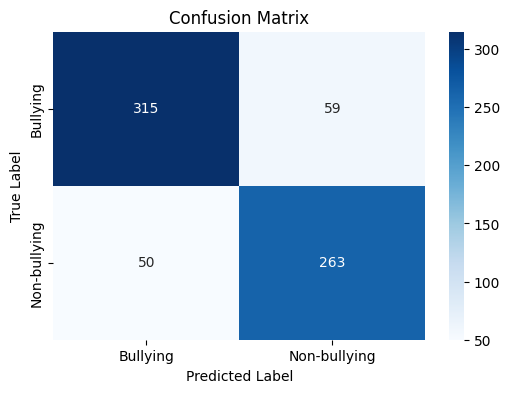

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Prediksi
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# 🔹 Get the class names for labels 0 and 1
class_names = le.inverse_transform([0, 1])

# 🔹 Classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# 🔹 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Tampilkan sebagai tabel (pandas DataFrame)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion Matrix (Tabel):\n")
print(cm_df)

# ✅ Visualisasi heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Uji-Coba 20 epoch set. + EarlyStopping :

In [35]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [36]:
model = Sequential()
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))  # pre-trained tidak di-train ulang
model.add(Bidirectional(GRU(128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,875,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875,300 (7.15 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,875,300 (7.15 MB)

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5938 - loss: 0.6672 - val_accuracy: 0.7582 - val_loss: 0.4910
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8118 - loss: 0.4474 - val_accuracy: 0.7800 - val_loss: 0.4556
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8114 - loss: 0.4157 - val_accuracy: 0.7873 - val_loss: 0.4652
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8426 - loss: 0.3627 - val_accuracy: 0.7909 - val_loss: 0.4216
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8582 - loss: 0.3412 - val_accuracy: 0.8109 - val_loss: 0.4495
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8708 - loss: 0.3145 - val_accuracy: 0.7982 - val_loss: 0.4487
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8859 - loss: 0.2815 - val_accuracy: 0.7909 - val_loss: 0.4561


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
              precision    recall  f1-score   support

    Bullying       0.81      0.88      0.84       374
Non-bullying       0.84      0.75      0.79       313

    accuracy                           0.82       687
   macro avg       0.83      0.82      0.82       687
weighted avg       0.82      0.82      0.82       687


Confusion Matrix (Tabel):

              Bullying  Non-bullying
Bullying           329            45
Non-bullying        77           236


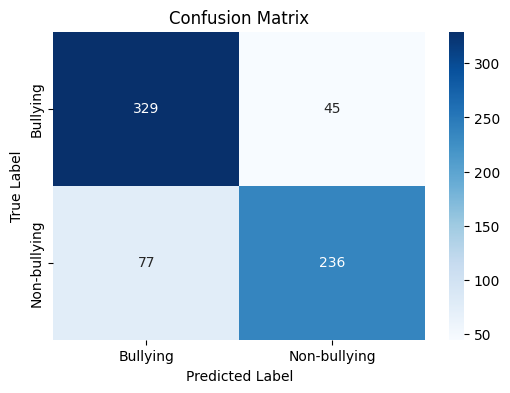

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Prediksi
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# 🔹 Get the class names for labels 0 and 1
class_names = le.inverse_transform([0, 1])

# 🔹 Classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# 🔹 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# ✅ Tampilkan sebagai tabel (pandas DataFrame)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print("\nConfusion Matrix (Tabel):\n")
print(cm_df)

# ✅ Visualisasi heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [40]:
import shutil, os

# Nama file notebook sesuai dengan yang kamu save di Drive
notebook_name = "Bi-GRU_AddedDataset.ipynb"
src_path = f"/content/drive/MyDrive/Colab Notebooks/{notebook_name}"
repo_dir = "/content/Indonesian-Cyberbullying-Detection-with-Distilbert"

if os.path.exists(src_path):
    shutil.copy(src_path, f"{repo_dir}/{notebook_name}")
    print(f"✅ Copied {notebook_name} ke repo folder.")
else:
    print(f"⚠️ Notebook tidak ditemukan di {src_path}. Periksa nama file!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/Indonesian-Cyberbullying-Detection-with-Distilbert/Bi-GRU_AddedDataset.ipynb'